# General Dependencies

In [175]:
import torch
# pip uninstall torch torchvision -y
# pip install torch torchvision --index-url https://download.pytorch.org/whl/cu129 INSTALL WITH CUDA INDEX look in google for pytorch start locally
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "CPU")

CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 5070 Ti


In [176]:
__file__ = "D:/GitHub/UmAutoplay/dev_play.ipynb"

In [177]:
from pathlib import Path
from core.settings import Settings
from core.utils.logger import setup_uma_logging, logger_uma

param_imgsz=832
param_conf=0.65
param_iou=0.45


PROJECT_ROOT = Path(__file__).resolve().parents[0]  # adjust to your repo root
setup_uma_logging(debug=True, show_func=False)
logger_uma.info("WORKING!")

21:59:52 INFO    1204325400.py:12: WORKING!


# Setup

In [178]:
from time import sleep

from core.controllers.bluestacks import BlueStacksController
from core.controllers.steam import SteamController
from core.controllers.android import ScrcpyController

# ctrl = SteamController("Umamusume", capture_client_only=True)
ctrl = ScrcpyController(window_title="23117RA68G")
# ctrl = BlueStacksController("BlueStacks App Player")

In [179]:
from core.perception.ocr.ocr_local import LocalOCREngine

# Forcing USE_FAST_OCR=True to debug
ocr = LocalOCREngine(
    text_detection_model_name="PP-OCRv5_mobile_det",
    text_recognition_model_name="en_PP-OCRv5_mobile_rec",
)

Creating model: ('PP-OCRv5_mobile_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\magod\.paddlex\official_models\PP-OCRv5_mobile_det`.


Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\magod\.paddlex\official_models\en_PP-OCRv5_mobile_rec`.


21:59:56 INFO    ocr_local.py:131: OCRInterface initialized | lang=en device=cpu


In [180]:
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.utils.waiter import Waiter,PollConfig
yolo_engine = LocalYOLOEngine(
    ctrl=ctrl,
    weights=Settings.YOLO_WEIGHTS_NAV,  # Settings.YOLO_WEIGHTS, Settings.YOLO_WEIGHTS_NAV
)
waiter = Waiter(ctrl, ocr, yolo_engine, PollConfig(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    poll_interval_s=0.5,
    timeout_s=4.0,
    tag="player",
))
print(yolo_engine.model.names)

22:00:11 INFO    yolo_local.py:30: Loading YOLO weights from: D:\GitHub\UmAutoplay\models\uma_nav.pt
{0: 'banner_opponent', 1: 'button_advance', 2: 'button_change', 3: 'button_green', 4: 'button_pink', 5: 'button_white', 6: 'race_daily_races', 7: 'race_daily_races_monies', 8: 'race_daily_races_monies_row', 9: 'race_daily_races_sp', 10: 'race_events', 11: 'race_room_match', 12: 'race_team_trials', 13: 'race_team_trials_go', 14: 'shop_clock', 15: 'shop_exchange', 16: 'shop_parfait', 17: 'shop_row', 18: 'shop_shoes', 19: 'shop_sp', 20: 'ui_enhance', 21: 'ui_home', 22: 'ui_race', 23: 'ui_scout', 24: 'ui_story'}


# Lookup

## Real Time

20:47:58 DEBUG   yolo_local.py:121: saved low-conf training debug -> D:\GitHub\UmAutoplay\debug\training\general\raw\general_20251007-204758_421_0.54.png | D:\GitHub\UmAutoplay\debug\training\general\overlay\general_20251007-204758_421_0.54.png
20:47:58 DEBUG   381326756.py:105: Screen Detection: Unknown | {'training_buttons': 0, 'tazuna': False, 'infirmary': False, 'rest': False, 'rest_summer': False, 'recreation': False, 'race_day': False, 'counts': {'ui_race': 1, 'ui_enhance': 1, 'ui_story': 1, 'button_white': 1, 'ui_home': 1, 'ui_scout': 1, 'race_daily_races_monies_row': 3, 'race_room_match': 1}}


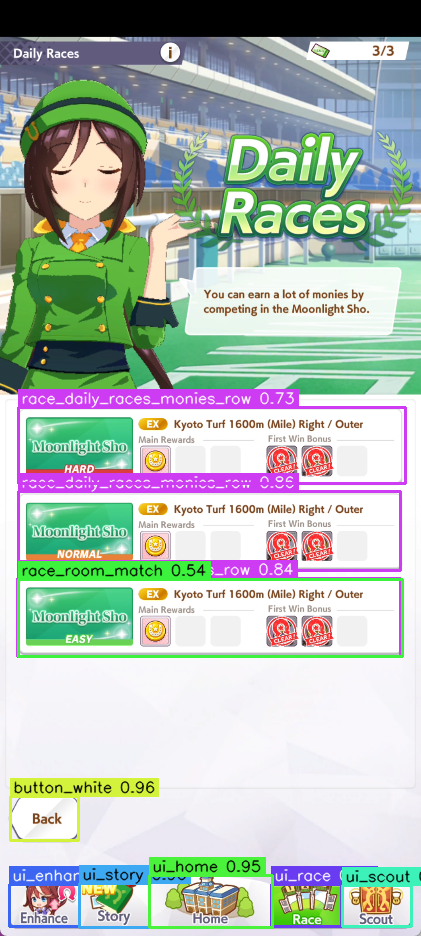

00 | ui_race              | conf=0.985 | xyxy=(271.5,884.9,341.1,926.9)
01 | ui_enhance           | conf=0.981 | xyxy=(9.0,884.5,79.9,926.9)
02 | ui_story             | conf=0.962 | xyxy=(79.3,883.9,149.9,927.0)
03 | button_white         | conf=0.959 | xyxy=(10.4,796.9,78.1,840.1)
04 | ui_home              | conf=0.954 | xyxy=(149.0,875.9,272.2,927.4)
05 | ui_scout             | conf=0.951 | xyxy=(342.0,885.1,411.2,926.8)
06 | race_daily_races_monies_row | conf=0.856 | xyxy=(18.1,491.8,400.6,570.1)
07 | race_daily_races_monies_row | conf=0.840 | xyxy=(17.9,578.7,400.3,656.5)
08 | race_daily_races_monies_row | conf=0.729 | xyxy=(18.4,407.1,405.6,483.2)
09 | race_room_match      | conf=0.536 | xyxy=(18.2,579.1,402.6,656.3)


In [155]:
from core.perception.analyzers.screen import classify_screen
from core.utils.img import bgr_to_pil, shrink
from core.utils.logger import logger_uma

import cv2
import numpy as np
import hashlib
import colorsys

def overlay_dets_to_bgr(
    pil_img,
    dets,
    *,
    box_color=(0, 255, 0),
    text_color=None,
    class_color_map=None,  # Optional: {'class_name': (B,G,R)}
):
    """
    Draw detection rectangles + labels on a copy of the PIL image, return BGR np.ndarray.
    `dets` is a list of DetectionDict: {"name": str, "conf": float, "xyxy": (x1,y1,x2,y2), "idx": int}
    - Each class gets its own color (stable across runs) unless overridden by `class_color_map`.
    - Text color is auto-selected (black/white) for contrast unless `text_color` is provided.
    """
    # PIL (RGB) -> BGR
    rgb = np.array(pil_img)
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

    def _stable_bgr_for_key(key: str) -> tuple[int, int, int]:
        """Generate a stable, distinct BGR color from a string key."""
        # Stable hash → hue [0, 360)
        h = int(hashlib.md5(key.encode("utf-8")).hexdigest()[:8], 16) % 360
        h /= 360.0
        s, v = 0.75, 0.95  # fairly vivid but not neon
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        return int(b * 255), int(g * 255), int(r * 255)  # RGB→BGR

    def _auto_text_bgr(bg_bgr: tuple[int, int, int]) -> tuple[int, int, int]:
        b, g, r = bg_bgr
        # Relative luminance (sRGB) to pick white/black for legibility
        y = 0.2126 * r + 0.7152 * g + 0.0722 * b
        return (255, 255, 255) if y < 140 else (0, 0, 0)

    for d in dets or []:
        x1, y1, x2, y2 = map(int, d.get("xyxy", (0, 0, 0, 0)))
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        label = f"{name} {conf:.2f}"

        # Choose per-class color:
        if class_color_map and name in class_color_map:
            this_box = class_color_map[name]
        else:
            # Use class name if available; else fall back to idx for stability
            key = name if name != "?" else str(d.get("idx", name))
            this_box = _stable_bgr_for_key(key)

        # Draw box
        cv2.rectangle(bgr, (x1, y1), (x2, y2), this_box, 2)

        # Draw label background
        (tw, th), bl = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        by1 = max(y1 - th - 6, 0)
        bx2 = min(x1 + tw + 6, bgr.shape[1] - 1)
        cv2.rectangle(bgr, (x1, by1), (bx2, by1 + th + 6), this_box, -1)

        # Text color (auto unless provided)
        tc = text_color if text_color is not None else _auto_text_bgr(this_box)

        # Draw text
        cv2.putText(
            bgr,
            label,
            (x1 + 3, by1 + th + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            tc,
            1,
            cv2.LINE_AA,
        )

    return bgr


# ---------------- your flow ----------------

assert ctrl.focus()

# NEW: recognize() returns (pil_image, meta_dict, dets_list)
game_img, meta, parsed_objects_screen = yolo_engine.recognize(
    imgsz=param_imgsz,
    conf=0.1,
    iou=param_iou,
    tag="general",
)

screen, info = classify_screen(
    parsed_objects_screen,
    lobby_conf=0.60,
    require_infirmary=True,   # set False if you want to allow tazuna-only
    training_conf=0.50,
    event_conf=0.60,
    names_map=None,           # or override class names here
)

logger_uma.debug(f"Screen Detection: {screen} | {info}")

# 3) visualize (now we draw overlays ourselves)
annot_bgr = overlay_dets_to_bgr(game_img, parsed_objects_screen)
display(bgr_to_pil(shrink(annot_bgr, 700)))

# 4) print raw detections
if not parsed_objects_screen:
    print("No detections.")
else:
    for i, d in enumerate(parsed_objects_screen):
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        x1, y1, x2, y2 = map(float, d.get("xyxy", (0, 0, 0, 0)))
        print(f"{i:02d} | {name:20s} | conf={conf:0.3f} | xyxy=({x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f})")


## Static

In [ ]:
from core.perception.analyzers.screen import classify_screen
from core.utils.img import bgr_to_pil, shrink
from core.utils.logger import logger_uma

import cv2
import numpy as np
import hashlib
import colorsys

def overlay_dets_to_bgr(
    pil_img,
    dets,
    *,
    box_color=(0, 255, 0),
    text_color=None,
    class_color_map=None,  # Optional: {'class_name': (B,G,R)}
):
    """
    Draw detection rectangles + labels on a copy of the PIL image, return BGR np.ndarray.
    `dets` is a list of DetectionDict: {"name": str, "conf": float, "xyxy": (x1,y1,x2,y2), "idx": int}
    - Each class gets its own color (stable across runs) unless overridden by `class_color_map`.
    - Text color is auto-selected (black/white) for contrast unless `text_color` is provided.
    """
    # PIL (RGB) -> BGR
    rgb = np.array(pil_img)
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

    def _stable_bgr_for_key(key: str) -> tuple[int, int, int]:
        """Generate a stable, distinct BGR color from a string key."""
        # Stable hash → hue [0, 360)
        h = int(hashlib.md5(key.encode("utf-8")).hexdigest()[:8], 16) % 360
        h /= 360.0
        s, v = 0.75, 0.95  # fairly vivid but not neon
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        return int(b * 255), int(g * 255), int(r * 255)  # RGB→BGR

    def _auto_text_bgr(bg_bgr: tuple[int, int, int]) -> tuple[int, int, int]:
        b, g, r = bg_bgr
        # Relative luminance (sRGB) to pick white/black for legibility
        y = 0.2126 * r + 0.7152 * g + 0.0722 * b
        return (255, 255, 255) if y < 140 else (0, 0, 0)

    for d in dets or []:
        x1, y1, x2, y2 = map(int, d.get("xyxy", (0, 0, 0, 0)))
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        label = f"{name} {conf:.2f}"

        # Choose per-class color:
        if class_color_map and name in class_color_map:
            this_box = class_color_map[name]
        else:
            # Use class name if available; else fall back to idx for stability
            key = name if name != "?" else str(d.get("idx", name))
            this_box = _stable_bgr_for_key(key)

        # Draw box
        cv2.rectangle(bgr, (x1, y1), (x2, y2), this_box, 2)

        # Draw label background
        (tw, th), bl = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        by1 = max(y1 - th - 6, 0)
        bx2 = min(x1 + tw + 6, bgr.shape[1] - 1)
        cv2.rectangle(bgr, (x1, by1), (bx2, by1 + th + 6), this_box, -1)

        # Text color (auto unless provided)
        tc = text_color if text_color is not None else _auto_text_bgr(this_box)

        # Draw text
        cv2.putText(
            bgr,
            label,
            (x1 + 3, by1 + th + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            tc,
            1,
            cv2.LINE_AA,
        )

    return bgr


# ---------------- your flow ----------------
from core.controllers.static_image import StaticImageController
from core.perception.yolo.yolo_local import LocalYOLOEngine


img = Image.open("tests/data/events/event_support_kitasan_paying_it_forward.png").convert("RGB")
ctrl_static = StaticImageController(img)
yolo_engine_static = LocalYOLOEngine(
    ctrl=ctrl_static,
    weights=Settings.YOLO_WEIGHTS_NAV,  # Settings.YOLO_WEIGHTS, Settings.YOLO_WEIGHTS_NAV
)


assert ctrl_static.focus()

# recognize() returns (pil_image, meta_dict, dets_list)
game_img, meta, parsed_objects_screen = yolo_engine_static.recognize(
    imgsz=832,
    conf=0.65,
    iou=0.45,
    tag="general",
)

screen, info = classify_screen(
    parsed_objects_screen,
    lobby_conf=0.60,
    require_infirmary=True,   # set False if you want to allow tazuna-only
    training_conf=0.50,
    event_conf=0.60,
    names_map=None,           # or override class names here
)

logger_uma.debug(f"Screen Detection: {screen} | {info}")

# 3) visualize (now we draw overlays ourselves)
annot_bgr = overlay_dets_to_bgr(game_img, parsed_objects_screen)
display(bgr_to_pil(shrink(annot_bgr, 700)))

# 4) print raw detections
if not parsed_objects_screen:
    print("No detections.")
else:
    for i, d in enumerate(parsed_objects_screen):
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        x1, y1, x2, y2 = map(float, d.get("xyxy", (0, 0, 0, 0)))
        print(f"{i:02d} | {name:20s} | conf={conf:0.3f} | xyxy=({x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f})")


In [ ]:
# Save segment
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Literal
from PIL import Image

def _clamp_box(x1: int, y1: int, x2: int, y2: int, w: int, h: int) -> Tuple[int, int, int, int]:
    x1 = max(0, min(x1, w - 1))
    y1 = max(0, min(y1, h - 1))
    x2 = max(0, min(x2, w - 1))
    y2 = max(0, min(y2, h - 1))
    # Ensure x2>x1 and y2>y1 (at least 1px box)
    if x2 <= x1: x2 = min(w - 1, x1 + 1)
    if y2 <= y1: y2 = min(h - 1, y1 + 1)
    return x1, y1, x2, y2

def _expand_box(x1: int, y1: int, x2: int, y2: int,
                w: int, h: int,
                pad_px: int = 0,
                pad_pct: float = 0.0) -> Tuple[int, int, int, int]:
    bw = max(1, x2 - x1)
    bh = max(1, y2 - y1)
    px = pad_px + int(bw * pad_pct)
    py = pad_px + int(bh * pad_pct)
    return _clamp_box(x1 - px, y1 - py, x2 + px, y2 + py, w, h)

def crop_by_class(
    pil_img: Image.Image,
    dets: List[Dict],
    class_name: str,
    out_dir: str,
    *,
    conf_min: float = 0.0,
    mode: Literal["best","all","index"] = "best",
    index: Optional[int] = None,          # used when mode="index" (0-based within filtered list)
    pad_px: int = 0,
    pad_pct: float = 0.0,                 # e.g. 0.05 → +5% of box size on all sides
    prefix: Optional[str] = None,
    fmt: str = "png",                     # "png" or "jpg"
) -> List[Tuple[str, Image.Image, Dict]]:
    """
    Find detections with name == class_name and save crops to `out_dir`.

    Returns a list of (saved_path, crop_image, det_dict) in the order saved.
    If nothing matches, returns [].

    - mode="best": only highest-confidence match
      mode="index": only the Nth match after sorting by confidence (index required)
      mode="all": save all matches (sorted by confidence desc)
    """
    # Filter & sort candidates
    cands = [d for d in (dets or []) if str(d.get("name","")) == class_name and float(d.get("conf",0.0)) >= conf_min]
    cands.sort(key=lambda d: float(d.get("conf", 0.0)), reverse=True)

    if not cands:
        return []

    if mode == "best":
        chosen = [cands[0]]
    elif mode == "index":
        if index is None or index < 0 or index >= len(cands):
            return []
        chosen = [cands[index]]
    else:  # "all"
        chosen = cands

    # Prepare output
    out_path = Path(out_dir)
    out_path.mkdir(parents=True, exist_ok=True)
    w, h = pil_img.size

    results: List[Tuple[str, Image.Image, Dict]] = []
    for rank, d in enumerate(chosen):
        x1, y1, x2, y2 = d.get("xyxy", (0,0,0,0))
        # Round to ints
        x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
        # Optional padding and clamp
        x1, y1, x2, y2 = _expand_box(x1, y1, x2, y2, w, h, pad_px=pad_px, pad_pct=pad_pct)

        crop = pil_img.crop((x1, y1, x2, y2))

        base = prefix or class_name
        conf = float(d.get("conf", 0.0))
        # e.g. ui_energy_rank0_0.95_0348-0090-0622-0132.png
        fname = f"{base}_rank{rank}_{conf:.2f}_{x1:04d}-{y1:04d}-{x2:04d}-{y2:04d}.{fmt.lower()}"
        save_path = str(out_path / fname)
        # Save with sane defaults
        save_kwargs = {}
        if fmt.lower() == "jpg":
            save_kwargs.update({"quality": 95, "optimize": True})
        crop.save(save_path, **save_kwargs)

        results.append((save_path, crop, d))

    return results

_ = crop_by_class(
    game_img,
    parsed_objects_screen,
    class_name="event_card",
    out_dir="assets",
    conf_min=0.60,
    mode="best",
    pad_pct=0.01,   # add ~X% padding for safety
)


# Segment by segment testing

## Static check

In [ ]:
# from core.controllers.static_image import StaticImageController
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.perception.ocr.ocr_local import LocalOCREngine
from core.utils.waiter import Waiter,PollConfig
from core.settings import Settings

img = Image.open("tests/data/events/event_support_kitasan_paying_it_forward.png").convert("RGB")
ctrl = StaticImageController(img)

assert ctrl.focus()
yolo_engine = LocalYOLOEngine(ctrl=ctrl)

det_name = "PP-OCRv5_mobile_det"
rec_name = "en_PP-OCRv5_mobile_rec"

ocr = LocalOCREngine(
    text_detection_model_name=det_name,
    text_recognition_model_name=rec_name,
)

waiter = Waiter(ctrl, ocr, yolo_engine, PollConfig(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    poll_interval_s=0.5,
    timeout_s=4.0,
    tag="player",
))


In [ ]:
from core.utils.event_processor import CATALOG_JSON, USER_PREFS, Catalog, UserPrefs

catalog = Catalog.load(CATALOG_JSON)
user_prefs = UserPrefs.load(USER_PREFS)

game_img, meta, parsed_objects_screen = yolo_engine.recognize(
    imgsz=832,
    conf=0.65,
    iou=0.45,
    tag="general",
)

event_flow = EventFlow(ctrl, ocr, yolo_engine, waiter, catalog, user_prefs)
decision = event_flow.process_event_screen(game_img, parsed_objects_screen)
decision

## Agent

## RUN

In [170]:
self = AgentNav(ctrl, ocr, yolo_engine, action="daily_races")

In [171]:
self.daily_race.run_race_and_collect()

21:05:42 INFO    1124092829.py:104: [DailyRace] NEXT (1)
21:05:44 INFO    1124092829.py:117: [DailyRace] race (2)


KeyboardInterrupt: 

In [151]:
ctrl.focus()
# daily_races, team_trials
agent_nav = AgentNav(ctrl, ocr, yolo_engine, action="daily_races")
agent_nav.run()

20:40:10 DEBUG   839701176.py:106: [AgentNav] screen=TeamTrialsBanners | info={'counts': {'banner_opponent': 3, 'ui_race': 1, 'ui_enhance': 1, 'ui_story': 1, 'button_white': 1, 'ui_home': 1, 'ui_scout': 1}}
20:40:10 INFO    839701176.py:125: [AgentNav] TeamTrials banners detected
20:40:13 INFO    2827816514.py:82: [TeamTrials] Clicked opponent banner
20:40:22 DEBUG   2827816514.py:97: [TeamTrials] pre-start greens: 1
20:41:01 DEBUG   waiter.py:140: [waiter] timeout after 2.00s (tag=team_trials_adv_advance)
20:41:01 DEBUG   2827816514.py:128: [TeamTrials] advances performed: 5
20:41:11 DEBUG   waiter.py:140: [waiter] timeout after 2.00s (tag=team_trials_shop_enter)
20:41:18 DEBUG   839701176.py:106: [AgentNav] screen=TeamTrialsBanners | info={'counts': {'ui_race': 1, 'ui_enhance': 1, 'ui_story': 1, 'ui_scout': 1, 'banner_opponent': 1, 'ui_home': 1}}
20:41:18 INFO    839701176.py:125: [AgentNav] TeamTrials banners detected
20:41:20 INFO    2827816514.py:82: [TeamTrials] Clicked opponent 

KeyboardInterrupt: 

# END